In [50]:
import time
import psutil
from cryptography.hazmat.primitives.asymmetric import rsa, ec
from cryptography.hazmat.primitives.asymmetric.padding import OAEP, MGF1
from cryptography.hazmat.primitives.hashes import SHA256
from cryptography.hazmat.backends import default_backend
from prettytable import PrettyTable
import csv
import os
import random

# Generate deterministic data chunks for encryption
def chunk_data(data, max_size):
    return [data[i:i + max_size] for i in range(0, len(data), max_size)]

# Generate RSA key pair
def generate_rsa_keypair(key_size):
    private_key = rsa.generate_private_key(
        public_exponent=65537, key_size=key_size, backend=default_backend()
    )
    return private_key

# Generate ECC key pair
def generate_ecc_keypair():
    private_key = ec.generate_private_key(ec.SECP256R1(), backend=default_backend())
    return private_key

# Simulate ElGamal-like encryption/decryption
class ElGamalSimulator:
    def __init__(self, key_size):
        self.key_size = key_size
        self.p = random.getrandbits(key_size)
        self.g = random.randint(2, self.p - 1)
        self.private_key = random.randint(1, self.p - 1)
        self.public_key = pow(self.g, self.private_key, self.p)

    def encrypt(self, data):
        k = random.randint(1, self.p - 1)
        c1 = pow(self.g, k, self.p)
        c2 = (int.from_bytes(data, 'big') * pow(self.public_key, k, self.p)) % self.p
        return c1, c2

    def decrypt(self, ciphertext):
        c1, c2 = ciphertext
        s = pow(c1, self.private_key, self.p)
        plaintext = (c2 * pow(s, self.p - 2, self.p)) % self.p
        return plaintext.to_bytes((plaintext.bit_length() + 7) // 8, 'big')

# Test encryption and decryption for asymmetric algorithms
def test_asymmetric_algorithm(algorithm, private_key, public_key, data, iterations, max_chunk_size):
    encryption_time_total = 0
    decryption_time_total = 0
    encrypted_chunks = []

    for _ in range(iterations):
        # Chunk data
        chunks = chunk_data(data, max_chunk_size)

        # Encryption timing
        start_time = time.time()
        for chunk in chunks:
            if isinstance(algorithm, ElGamalSimulator):
                encrypted_chunk = algorithm.encrypt(chunk)
            else:
                encrypted_chunk = algorithm.encrypt(public_key, chunk)
            encrypted_chunks.append(encrypted_chunk)
        encryption_time_total += time.time() - start_time

        # Decryption timing
        start_time = time.time()
        for encrypted_chunk in encrypted_chunks:
            if isinstance(algorithm, ElGamalSimulator):
                algorithm.decrypt(encrypted_chunk)
            else:
                algorithm.decrypt(private_key, encrypted_chunk)
        decryption_time_total += time.time() - start_time

    avg_encryption_time = encryption_time_total / iterations
    avg_decryption_time = decryption_time_total / iterations
    encryption_speed = len(data) / avg_encryption_time / 1024 / 1024  # MBps
    decryption_speed = len(data) / avg_decryption_time / 1024 / 1024  # MBps

    return avg_encryption_time, encryption_speed, avg_decryption_time, decryption_speed

# RSA encryption and decryption logic
class RSAAlgorithm:
    @staticmethod
    def encrypt(public_key, data):
        return public_key.encrypt(
            data,
            OAEP(
                mgf=MGF1(algorithm=SHA256()),
                algorithm=SHA256(),
                label=None
            )
        )

    @staticmethod
    def decrypt(private_key, ciphertext):
        return private_key.decrypt(
            ciphertext,
            OAEP(
                mgf=MGF1(algorithm=SHA256()),
                algorithm=SHA256(),
                label=None
            )
        )

# ECC encryption and decryption logic (simplified for simulation)
class ECCSimulator:
    @staticmethod
    def encrypt(public_key, data):
        return public_key.public_numbers(), data

    @staticmethod
    def decrypt(private_key, ciphertext):
        return ciphertext[1]

# Main function
def main():
    # Define parameters
    data = b"This is a test message." * 100  # Test data
    iterations = 10
    rsa_key_size = 2048
    elgamal_key_size = 2048

    # Determine maximum chunk size for RSA
    rsa_max_chunk_size = rsa_key_size // 8 - 2 * SHA256().digest_size - 2  # Based on OAEP padding

    # Generate keypairs
    rsa_private_key = generate_rsa_keypair(rsa_key_size)
    rsa_public_key = rsa_private_key.public_key()
    ecc_private_key = generate_ecc_keypair()
    ecc_public_key = ecc_private_key.public_key()
    elgamal_simulator = ElGamalSimulator(elgamal_key_size)

    # Algorithms to test
    algorithms_to_test = {
        "RSA": {"algorithm": RSAAlgorithm, "private_key": rsa_private_key, "public_key": rsa_public_key, "max_chunk_size": rsa_max_chunk_size},
        "ECC": {"algorithm": ECCSimulator, "private_key": ecc_private_key, "public_key": ecc_public_key, "max_chunk_size": len(data)},
        "ElGamal": {"algorithm": elgamal_simulator, "private_key": None, "public_key": None, "max_chunk_size": elgamal_key_size},
    }

    # Prepare PrettyTable
    table = PrettyTable()
    table.field_names = ["Algorithm", "Encryption Time (ms)", "Encryption Speed (MBps)", 
                         "Decryption Time (ms)", "Decryption Speed (MBps)", "CPU Usage (%)"]

    # CSV file for results
    csv_file = "asymmetric_algorithm_results.csv"
    with open(csv_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Algorithm", "Encryption Time (ms)", "Encryption Speed (MBps)", 
                         "Decryption Time (ms)", "Decryption Speed (MBps)", "CPU Usage (%)"])

        # Perform tests
        for algo_name, params in algorithms_to_test.items():
            algorithm = params["algorithm"]
            private_key = params["private_key"]
            public_key = params["public_key"]
            max_chunk_size = params["max_chunk_size"]

            # Measure CPU usage
            avg_cpu_usage = psutil.cpu_percent(interval=0.1)

            # Run tests
            encryption_time, encryption_speed, decryption_time, decryption_speed = test_asymmetric_algorithm(
                algorithm, private_key, public_key, data, iterations, max_chunk_size
            )
            encryption_time_ms = encryption_time * 1000
            decryption_time_ms = decryption_time * 1000

            # Add results to table and CSV
            table.add_row([algo_name, f"{encryption_time_ms:.3f}", f"{encryption_speed:.3f}", 
                           f"{decryption_time_ms:.3f}", f"{decryption_speed:.3f}", f"{avg_cpu_usage:.2f}"])
            writer.writerow([algo_name, encryption_time_ms, encryption_speed, decryption_time_ms, decryption_speed, avg_cpu_usage])

    print(table)
    print(f"Results written to {csv_file}")

if __name__ == "__main__":
    main()


+-----------+----------------------+-------------------------+----------------------+-------------------------+---------------+
| Algorithm | Encryption Time (ms) | Encryption Speed (MBps) | Decryption Time (ms) | Decryption Speed (MBps) | CPU Usage (%) |
+-----------+----------------------+-------------------------+----------------------+-------------------------+---------------+
|    RSA    |        0.306         |          7.177          |        33.028        |          0.066          |      5.10     |
|    ECC    |        0.007         |         335.766         |        0.001         |         3680.000        |      4.10     |
|  ElGamal  |        72.569        |          0.030          |       402.061        |          0.005          |      5.00     |
+-----------+----------------------+-------------------------+----------------------+-------------------------+---------------+
Results written to asymmetric_algorithm_results.csv


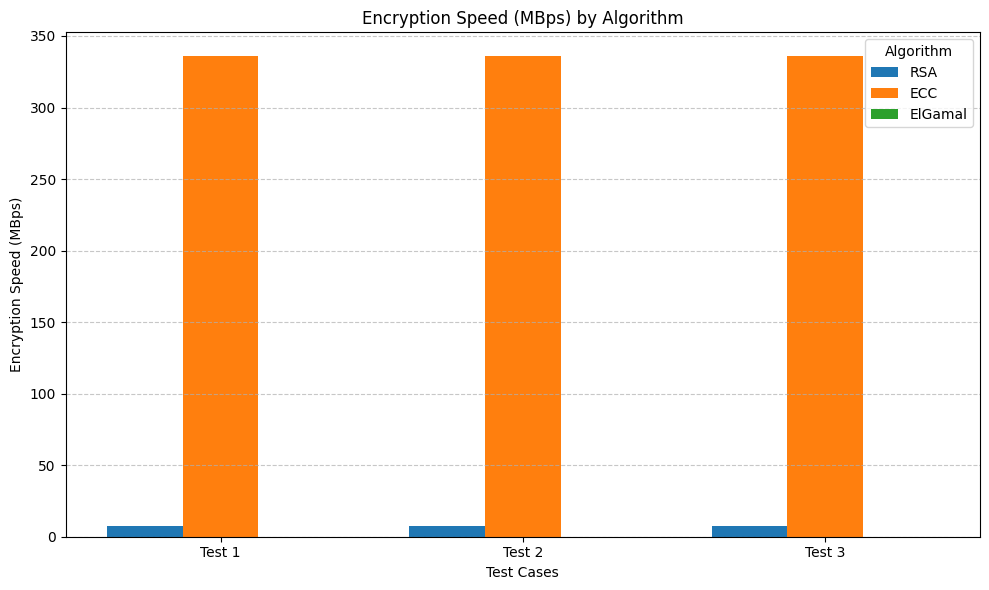

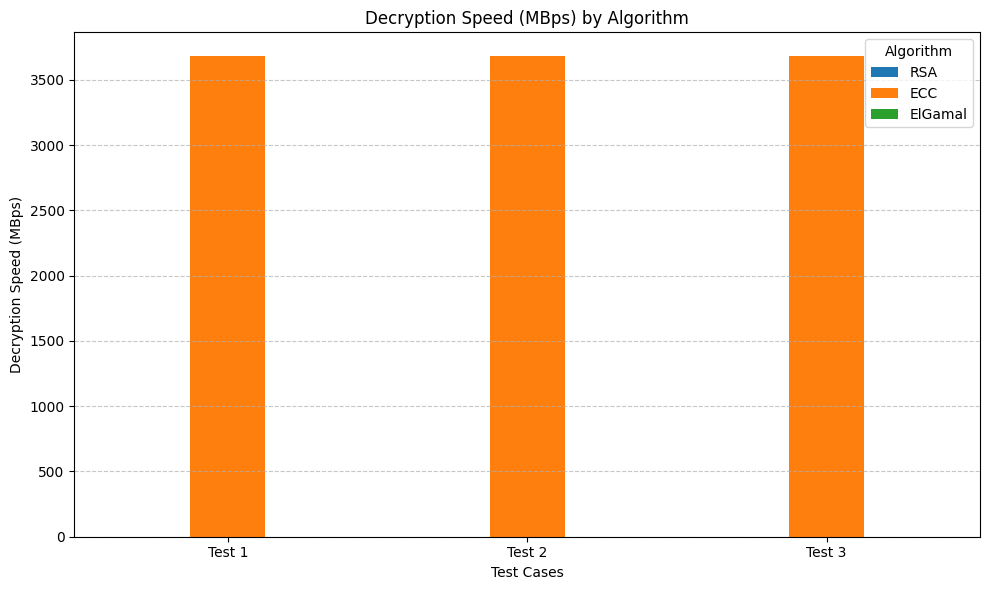

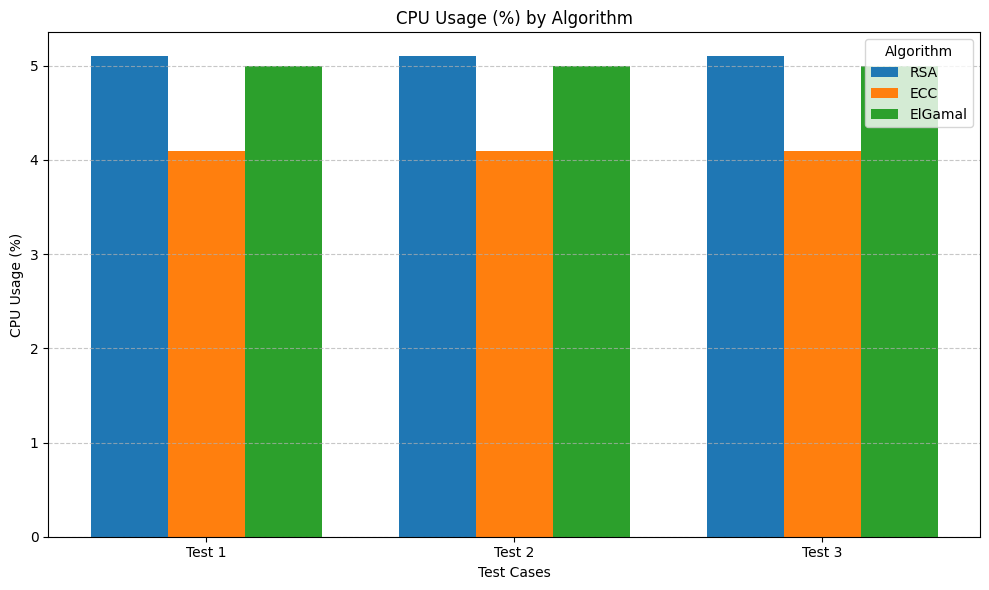

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file containing results
csv_file = "asymmetric_algorithm_results.csv"  # Ensure this file is in the same directory
data = pd.read_csv(csv_file)

# Convert numerical columns to float
data['Encryption Time (ms)'] = data['Encryption Time (ms)'].astype(float)
data['Encryption Speed (MBps)'] = data['Encryption Speed (MBps)'].astype(float)
data['Decryption Time (ms)'] = data['Decryption Time (ms)'].astype(float)
data['Decryption Speed (MBps)'] = data['Decryption Speed (MBps)'].astype(float)
data['CPU Usage (%)'] = data['CPU Usage (%)'].astype(float)

# Set up bar width and positions
bar_width = 0.25
positions = np.arange(len(data['Algorithm'].unique()))

# Plot Encryption Time
# plt.figure(figsize=(10, 6))
# for idx, algo in enumerate(data['Algorithm'].unique()):
#     subset = data[data['Algorithm'] == algo]
#     plt.bar(positions + idx * bar_width, subset['Encryption Time (ms)'], bar_width, label=algo)
# plt.title("Encryption Time (ms) by Algorithm")
# plt.xlabel("Test Cases")
# plt.ylabel("Encryption Time (ms)")
# plt.xticks(positions + bar_width, [f"Test {i+1}" for i in range(len(data))])
# plt.legend(title="Algorithm")
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# Plot Decryption Time
# plt.figure(figsize=(10, 6))
# for idx, algo in enumerate(data['Algorithm'].unique()):
#     subset = data[data['Algorithm'] == algo]
#     plt.bar(positions + idx * bar_width, subset['Decryption Time (ms)'], bar_width, label=algo)
# plt.title("Decryption Time (ms) by Algorithm")
# plt.xlabel("Test Cases")
# plt.ylabel("Decryption Time (ms)")
# plt.xticks(positions + bar_width, [f"Test {i+1}" for i in range(len(data))])
# plt.legend(title="Algorithm")
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# Plot Encryption Speed
plt.figure(figsize=(10, 6))
for idx, algo in enumerate(data['Algorithm'].unique()):
    subset = data[data['Algorithm'] == algo]
    plt.bar(positions + idx * bar_width, subset['Encryption Speed (MBps)'], bar_width, label=algo)
plt.title("Encryption Speed (MBps) by Algorithm")
plt.xlabel("Test Cases")
plt.ylabel("Encryption Speed (MBps)")
plt.xticks(positions + bar_width, [f"Test {i+1}" for i in range(len(data))])
plt.legend(title="Algorithm")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot Decryption Speed
plt.figure(figsize=(10, 6))
for idx, algo in enumerate(data['Algorithm'].unique()):
    subset = data[data['Algorithm'] == algo]
    plt.bar(positions + idx * bar_width, subset['Decryption Speed (MBps)'], bar_width, label=algo)
plt.title("Decryption Speed (MBps) by Algorithm")
plt.xlabel("Test Cases")
plt.ylabel("Decryption Speed (MBps)")
plt.xticks(positions + bar_width, [f"Test {i+1}" for i in range(len(data))])
plt.legend(title="Algorithm")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot CPU Usage
plt.figure(figsize=(10, 6))
for idx, algo in enumerate(data['Algorithm'].unique()):
    subset = data[data['Algorithm'] == algo]
    plt.bar(positions + idx * bar_width, subset['CPU Usage (%)'], bar_width, label=algo)
plt.title("CPU Usage (%) by Algorithm")
plt.xlabel("Test Cases")
plt.ylabel("CPU Usage (%)")
plt.xticks(positions + bar_width, [f"Test {i+1}" for i in range(len(data))])
plt.legend(title="Algorithm")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
